In [1]:
import os
import pandas as pd
import sklearn
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
import tensorflow as tf
import numpy as np

# root data directory
data_dir = 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'
# list of file names
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
print(filenames)


def get_lines(file_name):
    """
    Reads the file_name and returns the content of the file as list
    """
    with open(file_name) as f:
        lines = f.readlines()
    return lines

validation_lines = get_lines(filenames[0])
test_lines = get_lines(filenames[1])
train_lines = get_lines(filenames[2])

print(f"size of train lines is {len(train_lines)}")
print(f"size of validation lines is {len(validation_lines)}")
print(f"size of test lines is {len(test_lines)}")

def create_data_set(lines):
    data = []
    items = []
    index = 0
    for line in lines:
        
        if line.startswith('\n'):
            for item in items:
                item['total_lines'] = index -1
                data.append(item)
            index = 0
            items = []
        else:
            tokens = line.split('\t')
        
            if len(tokens) > 1:
                item = {'line_number':index,'target': tokens[0],'text':tokens[1].strip() ,'total_lines' :index}
                items.append(item)
                index = index + 1
    return data

train_data = create_data_set(train_lines)
validation_data = create_data_set(validation_lines)
test_data = create_data_set(test_lines)

print(f"size of train data is {len(train_data)}")
print(f"size of validation data is {len(validation_data)}")
print(f"size of test data is {len(test_data)}")

train_df = pd.DataFrame(train_data)
val_df   = pd.DataFrame(validation_data)
test_df  = pd.DataFrame(test_data)

train_sentences = train_df['text'].tolist()
val_sentences   = val_df['text'].tolist()
test_sentences  = test_df['text'].tolist()

onehot = OneHotEncoder(sparse_output=False)
train_label_one_hot = tf.constant(onehot.fit_transform(train_df['target'].to_numpy().reshape(-1,1)))
val_label_one_hot    = tf.constant(onehot.transform(val_df['target'].to_numpy().reshape(-1,1)))
test_label_one_hot   = tf.constant(onehot.transform(test_df['target'].to_numpy().reshape(-1,1)))
print('one hot encoding')
print(train_label_one_hot[0],val_label_one_hot[0],test_label_one_hot[0])

# label encoder
labelencode = LabelEncoder()
train_label_encoded = labelencode.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
val_label_encoded = labelencode.transform(val_df['target'].to_numpy().reshape(-1,1))
test_label_encoded = labelencode.transform(test_df['target'].to_numpy().reshape(-1,1))
print('label encoding...')
print(train_label_encoded[0],val_label_encoded[0],test_label_encoded[0])

print('classnames')
classnames = labelencode.classes_
print('class name = ', classnames, 'length of classes =', len(classnames))

# create text vectorizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

lengths = [len(sen.split()) for sen in train_sentences]
print('mean tokens in each sentences ', np.mean(lengths))
output_sequence_length = int(np.percentile(lengths,95))

max_tokens = 68000
text_vectorization = TextVectorization(max_tokens=max_tokens,
                                      output_sequence_length=output_sequence_length)

text_vectorization.adapt(train_sentences)
rct_20k_text_vocab = text_vectorization.get_vocabulary()

2023-07-01 09:34:05.393787: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt', 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt', 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']
size of train lines is 210040
size of validation lines is 35212
size of test lines is 35135
size of train data is 180040
size of validation data is 30212
size of test data is 30135


2023-07-01 09:34:15.695205: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-01 09:34:15.707851: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-01 09:34:15.708694: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-01 09:34:15.714093: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-01 09:34:15.714651: I tensorflow/compile

one hot encoding
tf.Tensor([0. 0. 0. 1. 0.], shape=(5,), dtype=float64) tf.Tensor([1. 0. 0. 0. 0.], shape=(5,), dtype=float64) tf.Tensor([1. 0. 0. 0. 0.], shape=(5,), dtype=float64)
label encoding...
3 0 0
classnames
class name =  ['BACKGROUND' 'CONCLUSIONS' 'METHODS' 'OBJECTIVE' 'RESULTS'] length of classes = 5
mean tokens in each sentences  26.338269273494777


In [2]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences,train_label_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences,val_label_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences,test_label_one_hot))

# for fast performance 
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset   = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset  = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [3]:
def positional_encoding(length, depth):
    depth = depth/2
    positions = np.arange(length)[:, np.newaxis]
    depths = np.arange(depth)[np.newaxis, :] / depth

    angle_rates = 1 / (10000 ** depths)
    angle_rads = positions * angle_rates

    pos_encoding = np.concatenate([np.sin(angle_rads), np.cos(angle_rads)],
                                  axis=-1)
    return tf.cast(pos_encoding, dtype=tf.float32)

In [4]:
class PositionalEmbedding(tf.keras.layers.Layer):

    def __init__(self, vocab_size, d_model, length=2048):
        super().__init__()
        self.embedding = tf.keras.layers.Embedding(input_dim=vocab_size,
                                                   output_dim=d_model,
                                                   mask_zero=True)
        self.positional_encoding = positional_encoding(length=length,
                                                       depth=d_model)
        
        self.length = length

    def call(self, x):
        x = self.embedding(x)
        x = x + self.positional_encoding[tf.newaxis, :self.length, :]
        return x
    
    def get_config(self):
        config = {
            'embedding':self.embedding,
            'positional_encoding':self.positional_encoding,
        }
        return config

In [5]:
max_tokens = 68000
lengths = [len(sen.split()) for sen in train_sentences]
output_sequence_length = int(np.percentile(lengths,95))
vocab_size = len(rct_20k_text_vocab)
output_dim = 128
output_units = 5
sample_sentence = train_sentences[0]
vocab_size,output_sequence_length,output_dim

(64841, 55, 128)

In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D, Dense

class PubMedTokenEmbeddingModel(tf.keras.Model):
    
    def __init__(self, max_tokens, output_seq_length, vocab_size, output_dim,output_units):
        super().__init__()
        self.text_vectorizer = TextVectorization(max_tokens=max_tokens, 
                                                 output_sequence_length=output_sequence_length,
                                                name="vectorization_layer")
        self.text_vectorizer.adapt(train_sentences)
        self.embedding = PositionalEmbedding(vocab_size=vocab_size,
                                   d_model=output_dim,
                                   length=output_sequence_length)
#         self.embedding = Embedding(input_dim=len(rct_20k_text_vocab),
#                      output_dim=128,
#                      mask_zero=True,
#                       name="token_embedding_layer")
        self.conv1D = Conv1D(filters=64,
                             kernel_size=5,
                             padding="same",
                             activation="relu",
                             name="conv1d_Layer")
        self.pooling = GlobalAveragePooling1D(name="global_average_pooling")
        self.outputs = Dense(output_units,activation="softmax", name="fully_connected")
        
    def call(self, inputs):
        x = self.text_vectorizer(inputs)
        x = self.embedding(x)
        x = self.conv1D(x)
        x = self.pooling(x)
        return self.outputs(x)
    
    def build_graph(self, raw_shape):
        x = tf.keras.layers.Input(shape=raw_shape)
        return Model(inputs=[x], outputs=self.call(x))
    
    
        
        

In [7]:
token_model = PubMedTokenEmbeddingModel(max_tokens=max_tokens,
                                       output_seq_length=output_sequence_length,
                                       vocab_size=vocab_size,
                                       output_dim=output_dim,
                                       output_units=output_units)

In [8]:
token_model([sample_sentence])

2023-07-01 09:35:11.068131: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-07-01 09:35:13.035635: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


<tf.Tensor: shape=(1, 5), dtype=float32, numpy=
array([[0.22512673, 0.20956591, 0.21844925, 0.23885961, 0.10799854]],
      dtype=float32)>

In [9]:
token_model(sample_sentence)

<tf.Tensor: shape=(1, 5), dtype=float32, numpy=
array([[0.22512673, 0.20956591, 0.21844925, 0.23885961, 0.10799854]],
      dtype=float32)>

In [10]:
token_model.compile(loss="categorical_crossentropy",
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

In [11]:
token_model_history = token_model.fit(train_dataset,
                                      steps_per_epoch=int(0.1*len(train_dataset)),
                                      epochs=1,
                                      validation_data=val_dataset,
                                      validation_steps=int(0.1*len(val_dataset)))

2023-07-01 09:35:13.218311: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [180040,5]
	 [[{{node Placeholder/_1}}]]
2023-07-01 09:35:14.476385: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f22d8009700 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-01 09:35:14.476474: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2023-07-01 09:35:14.548024: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-01 09:35:15.067540: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  

562/562 [==============================] - ETA: 0s - loss: 1.1245 - accuracy: 0.5292

2023-07-01 09:36:15.868379: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [30212,5]
	 [[{{node Placeholder/_1}}]]


562/562 [==============================] - 64s 108ms/step - loss: 1.1245 - accuracy: 0.5292 - val_loss: 0.7472 - val_accuracy: 0.7078


In [12]:
token_model.evaluate(val_dataset)

945/945 [==============================] - 10s 10ms/step - loss: 0.7500 - accuracy: 0.7056


[0.7500398755073547, 0.7055805921554565]

In [13]:
token_model.summary()

Model: "pub_med_token_embedding_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vectorization_layer (TextVe  multiple                 0         
 ctorization)                                                    
                                                                 
 positional_embedding (Posit  multiple                 8299648   
 ionalEmbedding)                                                 
                                                                 
 conv1d_Layer (Conv1D)       multiple                  41024     
                                                                 
 global_average_pooling (Glo  multiple                 0         
 balAveragePooling1D)                                            
                                                                 
 fully_connected (Dense)     multiple                  325       
                                     

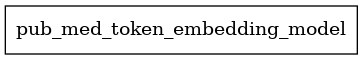

In [14]:
from tensorflow.keras.utils import plot_model

plot_model(token_model, show_shapes=True)

In [17]:
token_model.save_weights('resources/model/pubmed_model4')

In [18]:
token_model_new = PubMedTokenEmbeddingModel(max_tokens=max_tokens,
                                       output_seq_length=output_sequence_length,
                                       vocab_size=vocab_size,
                                       output_dim=output_dim,
                                       output_units=output_units)

In [22]:
token_model_new.compile(loss="categorical_crossentropy",
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

In [23]:
token_model_new.load_weights('resources/model/pubmed_model4')

In [24]:
token_model_new.evaluate(val_dataset)

945/945 [==============================] - 11s 11ms/step - loss: 0.7500 - accuracy: 0.7056


[0.7500398755073547, 0.7055805921554565]

In [ ]:
import tensorflow as tf
tf.__version__